*Predicting Freezing of Gait in Parkinson’s Disease Patients*

This project is developing a predictive model for forecasting "freezing of gait" (FOG) episodes from accelerometer data in Parkinson's disease patients. FOG is the most common motor symptom associated with unsteadiness, and difficulty in moving or walking, sometimes leading to falls and injuries. It is proposed that the developed model predicts the probabilistic occurrence of freezing events at each point in time.

Step 1:

In [ ]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


Step 2:

Code loads multiple .txt files from a specified directory (dataset), reads each file as a DataFrame, and concatenates them into a single DataFrame called data.

In [2]:
# Loading and Combining All `.txt` Files
# Update `file_directory` with the path to your `.txt` files.
file_directory = "dataset"  # Replace this with the path to your files in Colab or Jupyter environment.
data_list = []
for filename in os.listdir(file_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(file_directory, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)
        data.columns = ["Time", "Ankle_x", "Ankle_y", "Ankle_z", "Thigh_x", "Thigh_y", "Thigh_z",
                        "Trunk_x", "Trunk_y", "Trunk_z", "Annotation"]
        data_list.append(data)

# Concatenate all data
data = pd.concat(data_list, ignore_index=True)
data.head()  # Display the first few rows to verify data loading

,Time,Ankle_x,Ankle_y,Ankle_z,Thigh_x,Thigh_y,Thigh_z,Trunk_x,Trunk_y,Trunk_z,Annotation
0,15,70,39,-970,0,0,0,0,0,0,0
1,31,70,39,-970,0,0,0,0,0,0,0
2,46,60,49,-960,0,0,0,0,0,0,0
3,62,60,49,-960,0,0,0,0,0,0,0
4,78,50,39,-960,0,0,0,0,0,0,0


Step 3:

Visualizes the difference in ankle acceleration between freezing and normal walking episodes in the gait dataset and also helps in identifying distinctive acceleration patterns associated with freezing, which the model will later learn to classify based on features extracted from these signals.

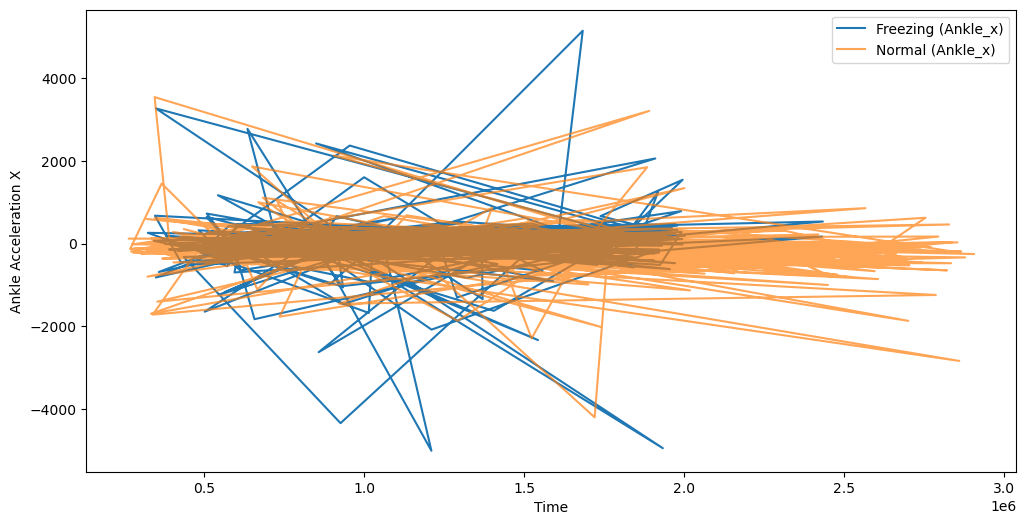

In [3]:
# Data Visualization
# Plot a sample of Freezing vs Normal walking data points for comparison.
# Sample 500 points each for freezing and normal data
freezing_data = data[data["Annotation"] == 2].sample(500, random_state=42)
normal_data = data[data["Annotation"] == 1].sample(500, random_state=42)

plt.figure(figsize=(12, 6))
plt.plot(freezing_data["Time"], freezing_data["Ankle_x"], label='Freezing (Ankle_x)')
plt.plot(normal_data["Time"], normal_data["Ankle_x"], label='Normal (Ankle_x)', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Ankle Acceleration X")
plt.legend()
plt.show()


Step 4: 

Calculates statistical features for each accelerometer axis in the dataset. It then extracts these features and prepares the target variable y for model training. These prepared X and y will be used for training and evaluating the machine learning model to classify freezing vs. normal walking events.

In [4]:
# Feature Engineering
# Defining a function to extract statistical features from each sensor axis.
def feature_extraction(df):
    features = pd.DataFrame()
    for axis in ["Ankle_x", "Ankle_y", "Ankle_z", "Thigh_x", "Thigh_y", "Thigh_z", "Trunk_x", "Trunk_y", "Trunk_z"]:
        features[f"{axis}_mean"] = df[axis].rolling(window=64).mean()
        features[f"{axis}_std"] = df[axis].rolling(window=64).std()
        features[f"{axis}_energy"] = (df[axis]**2).rolling(window=64).mean()
    features["Annotation"] = df["Annotation"]
    features = features.dropna()
    return features

# Extracting features and labels
features = feature_extraction(data)
X = features.drop("Annotation", axis=1)
y = features["Annotation"].apply(lambda x: 1 if x == 2 else 0)  # 1 for freezing, 0 for normal


Step 5:

Standardizes the feature set, splits it into training and testing sets, and prepares it for model training. Ensures that the model can learn effectively from the data and that its performance can be properly evaluated on a separate test set.

In [5]:
# Data Preprocessing
# Standardize the feature set.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Step 6:

Trains a Random Forest Classifier on the training data and then evaluates its performance on the test set.

In [ ]:
# Model Training
# Training a Random Forest Classifier.
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


Step 7: Model Evaluation

In [8]:
# Prediction and Evaluation
# Prediction and Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    361238
           1       1.00      0.98      0.99     22327

    accuracy                           1.00    383565
   macro avg       1.00      0.99      0.99    383565
weighted avg       1.00      1.00      1.00    383565

ROC-AUC Score: 0.9999334933040724


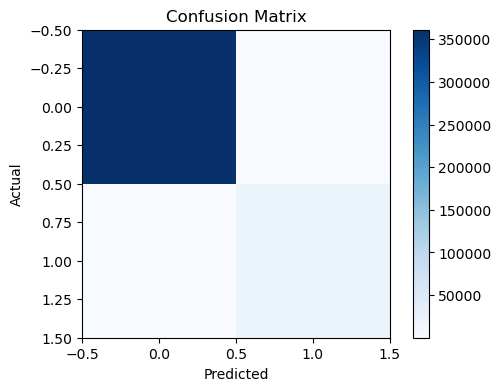

In [9]:
# Confusion Matrix
# Display the confusion matrix to visualize the model's performance.

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
print(conf_matrix)


[[361140     98]
 [   473  21854]]


Step 8: Feature Importance

Visualizes the importance of each feature in the Random Forest model, helping to identify which features contribute most to the model’s predictions. Rranked from least to most important.


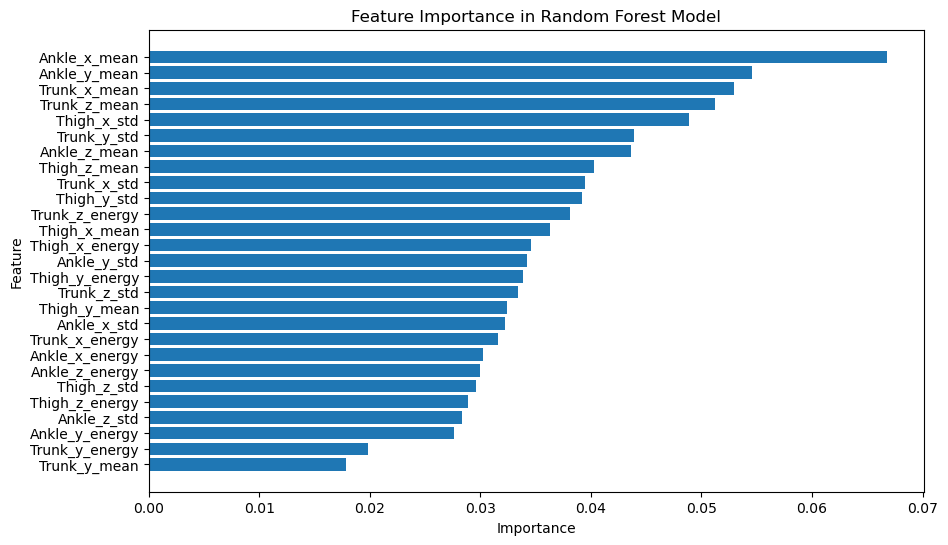

In [11]:
#  Feature Importance Visualization**
# Show the importance of each feature in the Random Forest model.
# Extract feature importance and plot
feature_importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx])
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
